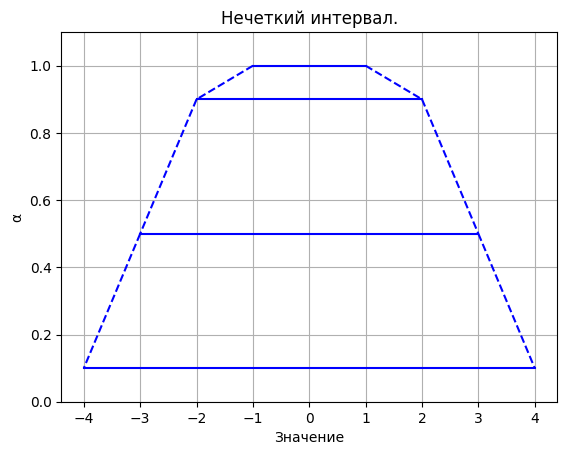

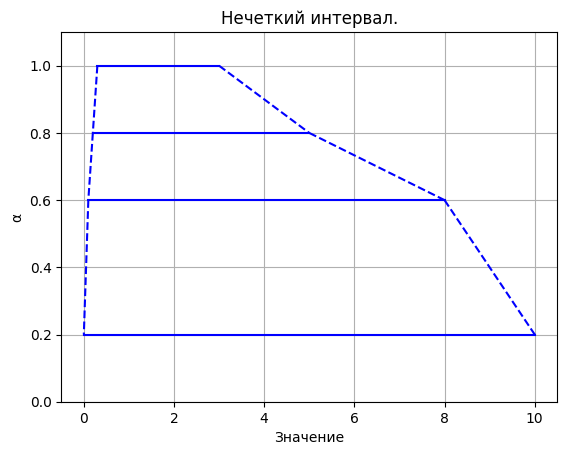

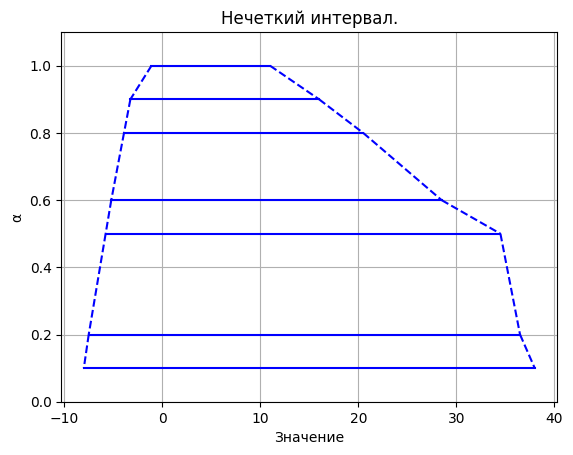

<ipython-input-51-af0847db2615>:606: RuntimeWarning: invalid value encountered in sqrt
  stdCint = np.sqrt([minVar, maxVar])


Предупреждение: Площадь гистограммы не равна 1.0 при условии симметричности границ значений PDF.


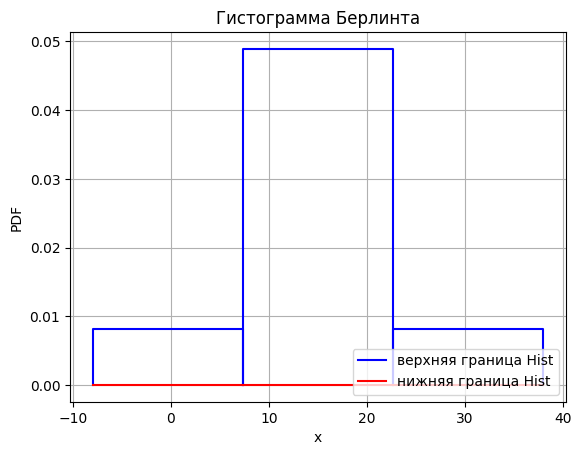

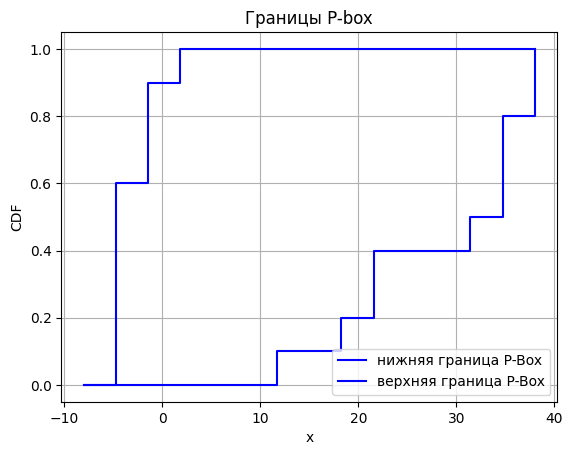

<ipython-input-51-af0847db2615>:151: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(np.mean(int), mass + 0.02, f'{float(mass):.3f}', horizontalalignment='center')


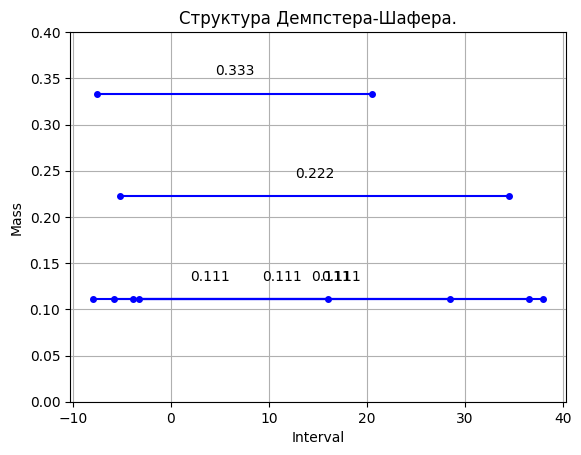

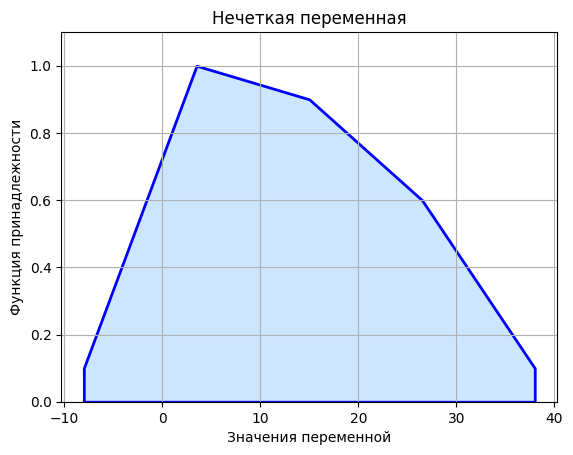

In [51]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize

# Преобразование разных типов представления неточных данных к формату,
# унифицированному для дальнейшего применения Data Reconciliation.

# Класс для Dempster-Shafer (структура Демпстера-Шафера)
class DempsterShafer:
    tolerance_threshold = 0.2  # Константа для объединения близких границ

    def __init__(self, intervals, masses):
        # Проверка входных аргументов
        if intervals.shape[1] != 2:
            raise ValueError('Поле Intervals должно быть матрицей размера N×2.')
        if np.any(intervals[:, 0] > intervals[:, 1]):
            raise ValueError('В поле Interval левые границы интервалов должны быть меньше правых границ.')
        if intervals.shape[0] != len(masses):
            raise ValueError('Количество фокальных элементов должно совпадать с переданным числом масс.')
        if np.any(masses < 0) or np.any(masses > 1):
            raise ValueError('Значения в поле Masses должны быть от 0 до 1.')
        threshold = 1e-2
        if abs(np.sum(masses) - 1) > threshold:
            raise ValueError(f'Сумма масс должна быть равна 1 (текущая сумма: {np.sum(masses):.6f})')

        self.Intervals = intervals
        self.Masses = masses.reshape(-1, 1)  # Превращение в вектор-столбец

    # Сложение по правилу Демпстера (нормализированное)
    def __add__(self, other):
        if not isinstance(other, DempsterShafer):
            raise TypeError('Оба операнда должны быть объектами типа DempsterShafer.')

        # Вычисление всех возможных сумм границ интервалов
        n, m = np.meshgrid(np.arange(self.Intervals.shape[0]), np.arange(other.Intervals.shape[0]))
        n = n.flatten()
        m = m.flatten()

        # Вычисление комбинированных интервалов
        sum_intervals = self.Intervals[n] + other.Intervals[m]

        # Вычисление комбинированных масс (произведение)
        comb_masses = self.Masses[n] * other.Masses[m]

        # Во избежание комбинаторного взрыва, объединяем близкие границы
        unique_int, idx = np.unique(sum_intervals, axis=0, return_inverse=True)
        sum_masses = np.bincount(idx, weights=comb_masses.flatten())

        # Нормализация после агрегации
        if len(sum_masses) < len(comb_masses):
            sum_masses = sum_masses / np.sum(sum_masses)

        return DempsterShafer(unique_int, sum_masses)

    # Умножение на константу
    def __rmul__(self, k):
        if not isinstance(k, (int, float)):
            raise TypeError('Операция умножения задана только для перемножения с коэффициентом.')
        z_intervals = k * self.Intervals
        if k < 0:
            z_intervals = z_intervals[:, [1, 0]]
        return DempsterShafer(z_intervals, self.Masses)

    def getStd(self, method='approximate'):
        intervals = self.Intervals  # Переменная для сокращенной записи
        masses = self.Masses.flatten()  # Переменная для сокращенной записи
        n = intervals.shape[0]

        if method == 'approximate':
            stdCint = np.array([np.nan, np.nan])
            # 1. Минимальное значение среднеквадратического отклонения
            # Минимальная дисперсия внутриинтервального распределения (0) + дисперсия центров интервалов
            midpoints = np.mean(intervals, axis=1)
            mean_mid = np.dot(masses, midpoints)
            between_var = np.sum(masses * (midpoints - mean_mid) ** 2)
            stdCint[0] = np.sqrt(between_var)

            # 2. Максимальное значение дисперсии
            # Максимальная дисперсия внутриинтервального распределения + дисперсия центров интервалов
            within_var = np.sum(masses * np.diff(intervals, axis=1) ** 2 / 4)
            # Случай, когда имеет место равномерное дискретное распределение, сосредоточенное в границах фокального интервала
            stdCint[1] = np.sqrt(within_var + between_var)

        elif method == 'accurate':
            # Оптимизация
            # 1. Минимальное значение дисперсии
            H = 2 * (np.diag(masses) - np.outer(masses, masses))
            lb = intervals[:, 0]  # Левые границы интервалов
            ub = intervals[:, 1]  # Правые границы интервалов

            def objective(x):
                return np.dot(x, np.dot(H, x))

            constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
            bounds = [(lb[i], ub[i]) for i in range(n)]
            res = minimize(objective, np.mean(intervals, axis=1), bounds=bounds, constraints=constraints)
            mean_min = np.dot(masses, res.x)
            minVar = np.sum(masses * (res.x - mean_min) ** 2)

            # Оптимизация
            # 2. Максимальное значение дисперсии
            maxVar = self.getStd(method='approximate')[1] ** 2  # Начальное приближение

            # Определение оптимальной точки (комбинаторный путь)
            if n <= 15:  # Практическое ограничение во избежание комбинаторного взрыва
                # Генерация всех возможных граничных точек (2^n)
                combinations = np.array([list(map(int, list(bin(i)[2:].zfill(n)))) for i in range(2 ** n)])
                combinations = combinations[:, ::-1]  # Двоичный порядок

                # Конвертация в граничные точки
                x_vals = intervals[:, 0] + (intervals[:, 1] - intervals[:, 0]) * combinations

                # Вычисление дисперсии для всех комбинаций
                for i in range(combinations.shape[0]):
                    x = x_vals[i]
                    current_mean = np.dot(masses, x)
                    current_var = np.sum(masses * (x - current_mean) ** 2)
                    if current_var > maxVar:
                        maxVar = current_var
            else:
                # Проверка экстремальных комбинаций граничных точек (ускорение)
                x_left = intervals[:, 0]
                var_left = np.sum(masses * (x_left - np.mean(x_left)) ** 2)
                x_right = intervals[:, 1]
                var_right = np.sum(masses * (x_right - np.mean(x_right)) ** 2)
                maxVar = max(maxVar, var_left, var_right)

            stdCint = np.sqrt([minVar, maxVar])

        else:
            raise ValueError('Аргумент method не задан. Допустимые значения: approximate, accurate.')

        return stdCint

    # Построение графика фокальных элементов с массами
    def plot(self):
        plt.figure()

        # Сортировка интервалов для лучшей визуализации
        sorted_int = np.sort(self.Intervals, axis=0)
        order = np.argsort(self.Intervals[:, 0])
        sorted_masses = self.Masses[order]

        # Отображение каждого фокального элемента
        for i in range(sorted_int.shape[0]):
            int = sorted_int[i]
            mass = sorted_masses[i]
            plt.plot(int, [mass, mass], 'b-o', linewidth=1.5, markerfacecolor='b', markersize=4)
            # Добавление текста о массах
            plt.text(np.mean(int), mass + 0.02, f'{float(mass):.3f}', horizontalalignment='center')

        # Форматирование графика
        plt.ylim([0, np.max(self.Masses) * (1 + self.tolerance_threshold)])
        plt.xlabel('Interval')
        plt.ylabel('Mass')
        plt.title('Структура Демпстера-Шафера.')
        plt.grid(True)
        plt.show()

    # Преобразование в PBox
    def DempsterShafer2PBox(self, numPoints=None):
        if numPoints is None:
            numPoints = len(self.Masses)
        # Дискретизация носителя
        x_vals = np.linspace(np.min(self.Intervals), np.max(self.Intervals), numPoints)
        borders = np.zeros((numPoints, 2))

        for i in range(numPoints):
            x = x_vals[i]
            # Belief (нижняя граница CDF)
            borders[i, 0] = np.sum(self.Masses[self.Intervals[:, 0] <= x])
            # Plausibility (верхняя граница CDF)
            borders[numPoints - i - 1, 1] = np.sum(self.Masses[self.Intervals[:, 1] >= x])

        lowerCDF = np.min(borders, axis=1)
        upperCDF = np.max(borders, axis=1)
        return PBox(x_vals, lowerCDF, upperCDF)

    # Преобразование в Hist
    def DempsterShafer2Hist(self, numBins=None):
        if numBins is None:
            numBins = len(self.Intervals)
        # Определение границ полос гистограммы
        all_points = np.concatenate([self.Intervals[:, 0], self.Intervals[:, 1]])
        edges = np.linspace(np.min(all_points), np.max(all_points), numBins + 1)

        lowerPDF = np.zeros(numBins)
        upperPDF = np.zeros(numBins)

        for i in range(numBins):
            left = edges[i]
            right = edges[i + 1]
            # Оценка границ вероятностей
            lowerPDF[i] = np.sum(self.Masses[(self.Intervals[:, 0] >= left) & (self.Intervals[:, 1] <= right)])
            upperPDF[i] = np.sum(self.Masses[(self.Intervals[:, 0] <= right) & (self.Intervals[:, 1] >= left)])

        # Нормализация по длине полос
        bin_widths = np.diff(edges)
        lowerPDF = lowerPDF / bin_widths
        upperPDF = upperPDF / bin_widths

        return Hist(edges, lowerPDF, upperPDF)

    # Преобразование в Fuzzy
    def DempsterShafer2Fuzzy(self, numPoints=None):
        if numPoints is None:
            numPoints = len(self.Masses)
        # Дискретизация носителя
        x_vals = np.linspace(np.min(self.Intervals), np.max(self.Intervals), numPoints)
        membership = np.zeros_like(x_vals)

        # Вычисление plausibility для каждой точки
        for i in range(len(x_vals)):
            x = x_vals[i]
            membership[i] = np.sum(self.Masses[(self.Intervals[:, 0] <= x) & (self.Intervals[:, 1] >= x)])

        return Fuzzy(x_vals, membership / np.max(membership))

    # Преобразование в FuzzyInterval
    def DempsterShafer2FuzzyInterval(self):
        # Используем значения масс в качестве уровней значимости
        sortedMasses = np.sort(self.Masses, axis=0)[::-1]
        alphaLevels = np.cumsum(sortedMasses)

        # Вычисление вложенных интервалов
        sorted_indices = np.argsort(self.Masses, axis=0)[::-1]
        intervals = self.Intervals[sorted_indices]
        intervals = intervals.reshape(-1, 2)

        for i in range(1, intervals.shape[0]):
            intervals[i, 0] = np.minimum(intervals[i - 1, 0], intervals[i, 0])
            intervals[i, 1] = np.maximum(intervals[i - 1, 1], intervals[i, 1])

        return FuzzyInterval(alphaLevels[::-1], intervals)


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Преобразование разных типов представления неточных данных к формату,
# унифицированному для дальнейшего применения Data Reconciliation.

# Класс для переменных типа Fuzzy (нечеткие переменные)
class Fuzzy:
    def __init__(self, universe, membership):
        # Проверка входных переменных
        universe = np.array(universe).flatten()  # перевод в вектор-строку
        membership = np.array(membership).flatten()  # перевод в вектор-строку

        if len(universe) != len(membership):
            raise ValueError('Поля Universe и Membership должны быть одинаковой длины.')
        if np.any(membership < 0) or np.any(membership > 1):
            raise ValueError('Значения функции принадлежности должны быть от 0 до 1.')

        # Порядок следования значений в поле universe - по возрастанию
        idx = np.argsort(universe)
        self.Universe = universe[idx]
        self.Membership = membership[idx]

    # Сложение с использованием принципа Заде (правило max-min)
    def __add__(self, other):
        # Создание результирующей переменной (поле Universe)
        min_z = self.Universe[0] + other.Universe[0]
        max_z = self.Universe[-1] + other.Universe[-1]
        z_step = min(np.diff(self.Universe[:2]), np.diff(other.Universe[:2]))
        z_universe = np.arange(min_z, max_z + z_step, z_step)

        # Выделение памяти под функцию принадлежности
        z_membership = np.zeros_like(z_universe)

        # Принцип Заде (композиция)
        for i, z in enumerate(z_universe):
            # Все возможные пары значений (x, y), для которых x + y = z
            x_vals = self.Universe
            y_vals = z - x_vals

            # Определение значений функции принадлежности для значений y_vals в B
            y_membership = interp1d(other.Universe, other.Membership, kind='linear', fill_value=0, bounds_error=False)(y_vals)

            # Вычисление минимакса от функции принадлежности
            combined = np.minimum(self.Membership, y_membership)
            z_membership[i] = np.max(combined)

        return Fuzzy(z_universe, z_membership)

    # Умножение на коэффициент
    def __rmul__(self, k):
        if not isinstance(k, (int, float)):
            raise TypeError('Операция умножения задана только для перемножения с коэффициентом.')
        z_membership = self.Membership
        z_universe = k * self.Universe
        if k < 0:
            z_universe = z_universe[::-1]
            z_membership = z_membership[::-1]
        return Fuzzy(z_universe, z_membership)

    # Вычисление вложенного (α-cut) интервала
    def alphaCut(self, alpha):
        # Валидация значения α
        if alpha < 0 or alpha > 1:
            raise ValueError('Уровень значимости должен быть числом в интервале [0, 1].')

        x = self.Universe  # Переменная для краткости
        mu = self.Membership  # Переменная для краткости

        # Значения индексов, когда Membership >= alpha
        above = mu >= alpha
        if not np.any(above):
            return np.array([np.nan, np.nan])

        # Левая граница
        first_idx = np.where(above)[0][0]
        if first_idx == 0:
            left = x[0]
        else:
            # Линейная интерполяция
            x_prev = x[first_idx - 1]
            x_curr = x[first_idx]
            mu_prev = mu[first_idx - 1]
            mu_curr = mu[first_idx]
            left = x_prev + (alpha - mu_prev) * (x_curr - x_prev) / (mu_curr - mu_prev)

        # Правая граница
        last_idx = np.where(above)[0][-1]
        if last_idx == len(x) - 1:
            right = x[-1]
        else:
            # Линейная интерполяция
            x_curr = x[last_idx]
            x_next = x[last_idx + 1]
            mu_curr = mu[last_idx]
            mu_next = mu[last_idx + 1]
            right = x_curr + (alpha - mu_curr) * (x_next - x_curr) / (mu_next - mu_curr)

        return np.array([left, right])

    def getStd(self, method='approximate'):
        if method == 'approximate':
            # Определение значений функции принадлежности для уровня α-cut, равного 0.05
            int0 = self.alphaCut(0.05)
            int1 = self.alphaCut(1 - np.finfo(float).eps)
            if np.any(np.isnan(int1)):
                stdCint = np.array([0, 0.25 * (int0[1] - int0[0])])
            else:
                val1 = 0.5 * (int1[0] - int0[0])
                val2 = 0.5 * (int0[1] - int1[1])
                stdCint = np.array([0, np.mean([val1, val2])])
        elif method == 'accurate':
            # Дискретизация уровней значимости
            alphaLevels = np.unique(np.concatenate([[0], self.Membership, [1]]))
            alphaLevels = np.sort(alphaLevels)[::-1]

            # Дискретизация поля Universe
            x = self.Universe
            nBins = len(x) - 1
            binEdges = x
            binMids = (x[:-1] + x[1:]) / 2

            # Матрицы ограничений для оптимизации
            A = []
            B = []

            # Построение ограничений из α-cuts
            for alpha in alphaLevels:
                interval = self.alphaCut(alpha)
                if np.any(np.isnan(interval)):
                    continue
                a, b = interval
                inBin = (binEdges[:-1] >= a) & (binEdges[1:] <= b)
                # Добавление ограничения: sum(p(inBin)) >= 1 - alpha
                A.append(-inBin.astype(float))
                B.append(-(1 - alpha))

            A = np.array(A)
            B = np.array(B)

            # Ограничение на нормировочное свойство
            Aeq = np.ones((1, nBins))
            Beq = np.array([1])

            # Неотрицательность вероятностей
            lb = np.zeros(nBins)
            ub = None

            # Оптимизация
            options = {'disp': False, 'maxiter': 10000}

            # 1. Минимальное значение дисперсии
            def objFun(p):
                return np.dot(p, binMids**2) - np.dot(p, binMids)**2

            p0 = np.ones(nBins) / nBins
            res = minimize(objFun, p0, constraints={'type': 'ineq', 'fun': lambda p: B - np.dot(A, p)},
                          bounds=[(0, None)] * nBins, options=options)
            minVar = objFun(res.x)
            if abs(minVar) < 1e-6:  # Устранение ошибок округления
                minVar = 0

            # 2. Максимальное значение дисперсии
            def objFunMax(p):
                return -(np.dot(p, binMids**2) - np.dot(p, binMids)**2)

            res = minimize(objFunMax, p0, constraints={'type': 'ineq', 'fun': lambda p: B - np.dot(A, p)},
                          bounds=[(0, None)] * nBins, options=options)
            maxVar = -objFunMax(res.x)

            stdCint = np.sqrt([minVar, maxVar])
        else:
            raise ValueError('Аргумент method не задан. Допустимые значения: approximate, accurate.')

        return stdCint

    # Отображение функции принадлежности на графике
    def plot(self):
        plt.figure()
        plt.fill_between(self.Universe, self.Membership, color=[0.8, 0.9, 1], edgecolor='b', linewidth=2)
        plt.xlabel('Значения переменной')
        plt.ylabel('Функция принадлежности')
        plt.title('Нечеткая переменная')
        plt.ylim([0, 1.1])
        plt.grid(True)
        plt.show()

    # Преобразование в PBox
    def Fuzzy2PBox(self, numPoints=None):
        if numPoints is None:
            numPoints = len(self.Universe)
        x_vals = np.linspace(np.min(self.Universe), np.max(self.Universe), numPoints)
        lowerCDF = np.zeros_like(x_vals)
        upperCDF = np.zeros_like(x_vals)

        for i, x in enumerate(x_vals):
            # Нижняя граница CDF = 1 - Possibility(X > x)
            bound = 1 - np.max(self.Membership[self.Universe > x], initial=0)
            lowerCDF[i] = bound if not np.isnan(bound) else 1
            # Верхняя граница CDF = 1 - Necessity(X > x)
            bound = np.max(self.Membership[self.Universe <= x], initial=0)
            upperCDF[i] = bound if not np.isnan(bound) else 0

        return PBox(x_vals, lowerCDF, upperCDF)

    # Преобразование в Hist
    def Fuzzy2Hist(self, numBins=None):
        if numBins is None:
            numBins = len(self.Universe)
        edges = np.linspace(np.min(self.Universe), np.max(self.Universe), numBins + 1)
        lowerProb = np.zeros(numBins)
        upperProb = np.zeros(numBins)

        for i in range(numBins):
            left = edges[i]
            right = edges[i + 1]
            # Определение полос
            in_bin = (self.Universe >= left) & (self.Universe <= right)
            if np.any(in_bin):
                lowerProb[i] = np.mean(in_bin) * np.min(self.Membership[in_bin])
                upperProb[i] = np.mean(in_bin) * np.max(self.Membership[in_bin])

        # Валидация
        if np.sum(lowerProb) > 1:
            raise ValueError('Оценка нижних границ вероятностей попадания в полосы содержит ошибку.')

        # Оценка значения PDF
        lowerPDF = lowerProb / np.diff(edges)
        upperPDF = upperProb / np.diff(edges)

        return Hist(edges, lowerPDF, upperPDF)

    # Преобразование в DempsterShafer
    def Fuzzy2DempsterShafer(self, numAlpha=None):
        if numAlpha is None:
            numAlpha = len(self.Universe)
        alphaLevels = np.linspace(0, 1, numAlpha + 1)
        alphaLevels = alphaLevels[1:]  # Исключаем ноль

        intervals = np.zeros((len(alphaLevels), 2))
        masses = np.diff(np.concatenate([[0], alphaLevels]))

        for i, alpha in enumerate(alphaLevels):
            intervals[i] = self.alphaCut(alpha)

        return DempsterShafer(intervals, masses)

    # Преобразование в FuzzyInterval
    def Fuzzy2FuzzyInterval(self, numAlpha=None):
        if numAlpha is None:
            numAlpha = len(self.Universe)
        alphaLevels = np.linspace(0, 1, numAlpha)
        alphaLevels = np.sort(alphaLevels)[::-1]

        intervals = np.zeros((len(alphaLevels), 2))
        for i, alpha in enumerate(alphaLevels):
            intervals[i] = self.alphaCut(alpha)

        return FuzzyInterval(alphaLevels, intervals)

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Преобразование разных типов представления неточных данных к формату,
# унифицированному для дальнейшего применения Data Reconciliation.

# Класс для переменных типа FuzzyInterval (нечеткий интервал)
class FuzzyInterval:
    def __init__(self, alphaLevels, intervals):
        # Проверка входных аргументов
        if intervals.shape[1] != 2:
            raise ValueError('Границы вложенных интервалов должны задаваться строкой из двух значений.')
        if len(alphaLevels) != intervals.shape[0]:
            raise ValueError('Количество уровней alpha-cut должно соответствовать числу вложенных интервалов.')
        if np.any((alphaLevels < 0-1e-6) | (alphaLevels > 1+1e-6)):
            raise ValueError('Уровни alpha-cut должны иметь значения в пределах от 0 до 1.')
        if np.any(intervals[:, 0] > intervals[:, 1]):
            raise ValueError('Правые границы вложенных интервалов должны быть меньше левых границ.')

        # Сортировка по значениям alpha-cut
        idx = np.argsort(alphaLevels)[::-1]
        self.AlphaLevels = np.array(alphaLevels)[idx]
        self.Intervals = np.array(intervals)[idx]

        # # Проверка вложенного характера интервалов Intervals:
        # # с уменьшением α-cut вложенные интервалы должны расширяться.
        # if np.any(self.Intervals[:, 0] != np.sort(self.Intervals[:, 0])[::-1]) or \
        #    np.any(self.Intervals[:, 1] != np.sort(self.Intervals[:, 1])):
        #     raise ValueError('Вложенность интервалов в поле Intervals нарушена.')

    # Определение величины возможного среднеквадратического отклонения (согласно теореме Крейновича-Тао).
    def getStd(self, method='approximate'):
        int = self.Intervals  # Переменная для краткости
        a = self.AlphaLevels  # Переменная для краткости
        widths = int[:, 1] - int[:, 0]  # Ширина интервалов

        if method == 'approximate':
            alpha = 0.05
            ind1 = np.where(a == alpha)[0]
            ind2 = np.where(a == 1)[0]
            if ind1.size > 0 and ind2.size > 0:
                stdCint = np.array([0, 0.25 * (widths[ind1[0]] - widths[ind2[0]])])
            else:
                ind1 = np.where(a > alpha)[0]
                if ind1.size == 0:
                    stdCint = np.array([0, 0.25 * widths[0]])
                else:
                    ind1 = ind1[-1]
                    if ind1 == 0:
                        stdCint = np.array([0, 0.25 * widths[ind1]])
                    else:
                        # Линейная интерполяция
                        width = (alpha - a[ind1 - 1]) * (widths[ind1] - widths[ind1 - 1]) / (a[ind1] - a[ind1 - 1]) + widths[ind1 - 1]
                        stdCint = np.array([0, 0.25 * width])
                    if ind2.size > 0:
                        stdCint[1] -= 0.25 * widths[ind2[0]]
        elif method == 'accurate':
            # Дискретизация носителя, используя границы вложенных интервалов
            breakpoints = np.unique(np.concatenate([self.Intervals[:, 0], self.Intervals[:, 1]]))
            nBins = len(breakpoints) - 1
            binEdges = np.sort(breakpoints)

            # Определение ограничений на вероятности из α-cuts
            A = []
            b = []
            for i in range(len(self.AlphaLevels)):
                alpha = self.AlphaLevels[i]
                a_int = self.Intervals[i, 0]
                b_int = self.Intervals[i, 1]
                inBin = (binEdges[:-1] >= a_int) & (binEdges[1:] <= b_int)

                # Добавление ограничения: sum(p(inBin)) >= 1 - alpha
                A.append(-inBin.astype(float))
                b.append(-(1 - alpha))

            A = np.array(A)
            b = np.array(b)

            # Добавление ограничений на сумму вероятностей
            Aeq = np.ones((1, nBins))
            beq = np.array([1])
            # Добавление ограничения на неотрицательность вероятностей
            lb = np.zeros(nBins)
            ub = None

            # Параметры промежутков
            binMids = (binEdges[:-1] + binEdges[1:]) / 2

            # 1. Минимальное значение дисперсии
            def objFun(p):
                return np.dot(p, binMids**2) - np.dot(p, binMids)**2

            p0 = np.ones(nBins) / nBins
            res = minimize(objFun, p0, constraints={'type': 'ineq', 'fun': lambda p: b - np.dot(A, p)},
                          bounds=[(0, None)] * nBins, options={'maxiter': 10000, 'disp': False})
            minVar = objFun(res.x)

            # 2. Максимальное значение дисперсии
            def objFunMax(p):
                return -(np.dot(p, binMids**2) - np.dot(p, binMids)**2)

            res = minimize(objFunMax, p0, constraints={'type': 'ineq', 'fun': lambda p: b - np.dot(A, p)},
                          bounds=[(0, None)] * nBins, options={'maxiter': 10000, 'disp': False})
            maxVar = -objFunMax(res.x)

            stdCint = np.sqrt([minVar, maxVar])
        else:
            raise ValueError('Аргумент method не задан. Допустимые значения: approximate, accurate.')

        return stdCint

    # Сложение с использованием принципа Заде (правило max-min)
    def __add__(self, other):
        if not isinstance(other, FuzzyInterval):
            raise TypeError('Оба операнда должны быть объектами типа FuzzyInterval.')

        # Комбинирование и сортировка уровней значимости
        combinedAlpha = np.unique(np.concatenate([self.AlphaLevels, other.AlphaLevels]))
        combinedAlpha = np.sort(combinedAlpha)[::-1]

        # Вычисление интервалов на каждом уровне значимости
        sumIntervals = np.zeros((len(combinedAlpha), 2))
        for i, alpha in enumerate(combinedAlpha):
            intA = self.getIntervalAtAlpha(alpha)
            intB = other.getIntervalAtAlpha(alpha)
            # Суммирование интервалов по интервальной арифметике
            sumIntervals[i] = [intA[0] + intB[0], intA[1] + intB[1]]

        return FuzzyInterval(combinedAlpha, sumIntervals)

    # Вложенный интервал на заданном уровне значимости (с интерполяцией)
    def getIntervalAtAlpha(self, alpha):
        if alpha < 0 or alpha > 1:
            raise ValueError('Значение alpha должно быть от 0 до 1.')

        # Граничные значения α
        idxHigh = np.where(self.AlphaLevels >= alpha)[0]
        idxLow = np.where(self.AlphaLevels <= alpha)[0]

        if idxHigh.size == 0:
            return self.Intervals[0]
        elif idxLow.size == 0:
            return self.Intervals[-1]
        elif idxHigh[-1] == idxLow[0]:  # Точное соответствие
            return self.Intervals[idxHigh[-1]]
        else:  # Линейная интерполяция
            idxHigh = idxHigh[-1]
            idxLow = idxLow[0]
            alphaHigh = self.AlphaLevels[idxHigh]
            alphaLow = self.AlphaLevels[idxLow]
            weight = (alpha - alphaLow) / (alphaHigh - alphaLow)

            # Интерполяция левых границ
            leftHigh = self.Intervals[idxHigh, 0]
            leftLow = self.Intervals[idxLow, 0]
            left = leftHigh + (leftLow - leftHigh) * (1 - weight)

            # Интерполяция правых границ
            rightHigh = self.Intervals[idxHigh, 1]
            rightLow = self.Intervals[idxLow, 1]
            right = rightHigh + (rightLow - rightHigh) * weight

            return np.array([left, right])

    # Умножение на коэффициент
    def __rmul__(self, k):
        if not isinstance(k, (int, float)):
            raise TypeError('Операция умножения задана только для перемножения с коэффициентом.')
        z_alphalevels = self.AlphaLevels
        z_intervals = k * self.Intervals
        if k < 0:
            z_intervals = z_intervals[:, [1, 0]]
        return FuzzyInterval(z_alphalevels, z_intervals)

    # Графическое отображение функции принадлежности нечеткого интервала
    def plot(self):
        plt.figure()

        # Отображение α-cuts
        for i in range(len(self.AlphaLevels)):
            a = self.Intervals[i, 0]
            b = self.Intervals[i, 1]
            alpha = self.AlphaLevels[i]
            plt.plot([a, b], [alpha, alpha], 'b-', linewidth=1.5)

            # Отображение вертикальных соединительных линий
            if i < len(self.AlphaLevels) - 1:
                next_a = self.Intervals[i + 1, 0]
                next_b = self.Intervals[i + 1, 1]
                plt.plot([a, next_a], [alpha, self.AlphaLevels[i + 1]], 'b--')
                plt.plot([b, next_b], [alpha, self.AlphaLevels[i + 1]], 'b--')

        plt.xlabel('Значение')
        plt.ylabel('α')
        plt.title('Нечеткий интервал.')
        plt.grid(True)
        plt.ylim([0, 1.1])
        plt.show()

    # Преобразование в PBox
    def FuzzyInterval2PBox(self, numPoints=None):
        if numPoints is None:
            numPoints = len(self.AlphaLevels)
        x_vals = np.linspace(np.min(self.Intervals), np.max(self.Intervals), numPoints)
        lowerCDF = np.zeros_like(x_vals)
        upperCDF = np.zeros_like(x_vals)

        for i, x in enumerate(x_vals):
            bound = np.max(self.AlphaLevels[self.Intervals[:, 0] < x], initial=0)
            upperCDF[i] = min(bound, 1) if bound.size > 0 else 0
            bound = 1 - np.max(self.AlphaLevels[self.Intervals[:, 1] > x], initial=0)
            lowerCDF[i] = max(bound, 0) if bound.size > 0 else 1

        return PBox(x_vals, lowerCDF, upperCDF)

    # Преобразование в Hist
    def FuzzyInterval2Hist(self, numBins=None):
        if numBins is None:
            numBins = len(self.AlphaLevels)
        # Определение границ полос гистограммы
        edges = np.linspace(np.min(self.Intervals), np.max(self.Intervals), numBins + 1)

        lowerPDF = np.zeros(numBins)
        upperPDF = np.zeros(numBins)

        for i in range(numBins):
            left = edges[i]
            right = edges[i + 1]

            # Определение максимального уровня значимости, при котором интервал содержит данную полосу
            containing = (self.Intervals[:, 0] <= left) & (self.Intervals[:, 1] >= right)
            if np.any(containing):
                max_alpha = np.max(self.AlphaLevels[containing])
            else:
                max_alpha = 0

            # Границы PDF пропорционально уровню значимости
            lowerPDF[i] = 0  # Консервативная нижняя граница
            upperPDF[i] = max_alpha

        # Определение границ значений PDF
        bin_widths = np.diff(edges)
        total_upper = np.sum(upperPDF * bin_widths)
        upperPDF = upperPDF / total_upper

        return Hist(edges, lowerPDF, upperPDF)

    # Преобразование в DempsterShafer
    def FuzzyInterval2DempsterShafer(self, method='fractional'):
        if method == 'fractional':
            # Вычисление масс из разностей значений уровня значимости
            masses = -0.5 * np.diff(np.concatenate([[0], self.AlphaLevels]))
            masses = np.concatenate([masses, masses])
            intervals = []
            if self.AlphaLevels[0] == 1:
                masses = np.concatenate([[1.0], masses])
                intervals = [self.Intervals[0]]
            intervals = np.concatenate([intervals, self.Intervals[1:, 0].reshape(-1, 1), self.Intervals[:-1, 0].reshape(-1, 1)], axis=1)
            intervals = np.concatenate([intervals, self.Intervals[:-1, 1].reshape(-1, 1), self.Intervals[1:, 1].reshape(-1, 1)], axis=1)
            # Удаление интервалов с нулевой массой
            valid = masses > 0
            ds = DempsterShafer(intervals[valid], masses[valid] / np.sum(masses[valid]))
        elif method == 'nested':
            masses = -np.diff(np.concatenate([[0], self.AlphaLevels]))
            # Удаление интервалов с нулевой массой
            valid = masses > 0
            ds = DempsterShafer(self.Intervals[valid], masses[valid] / np.sum(masses[valid]))
        else:
            raise ValueError('Поле method может быть равно только fractional или nested.')

        return ds

    # Преобразование в Fuzzy
    def FuzzyInterval2Fuzzy(self, numPoints=None):
        if numPoints is None:
            numPoints = len(self.AlphaLevels)
        # Дискретизация носителя
        x_vals = np.linspace(np.min(self.Intervals), np.max(self.Intervals), numPoints)
        membership = np.zeros_like(x_vals)

        # Оценка уровня значимости как максимального alpha, при котором вложенный интервал содержит x
        for i, x in enumerate(x_vals):
            contains_x = (self.Intervals[:, 0] <= x) & (self.Intervals[:, 1] >= x)
            if np.any(contains_x):
                membership[i] = np.max(self.AlphaLevels[contains_x])

        return Fuzzy(x_vals, membership)


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Преобразование разных типов представления неточных данных к формату,
# унифицированному для дальнейшего применения Data Reconciliation.

# Класс для Hist (дискретизированная гистограмма, pdf)
class Hist:  # дискретизированная гистограмма
    tolerance_threshold = 0.1  # Константа для объединения близких границ

    def __init__(self, x, lowerPDF, upperPDF):
        # Проверка размерностей входных данных
        if len(x) < 2:
            raise ValueError('В гистограмме должна быть хотя бы одна полоса.')
        if len(x) != len(lowerPDF) + 1 or len(x) != len(upperPDF) + 1:
            raise ValueError('lowerPDF и upperPDF должны быть векторами одинакового размера, x иметь на одно значение больше.')
        if np.any(lowerPDF > upperPDF):
            raise ValueError('Нижние границы полос гистограммы не должны превышать верхние границы гистограммы для всех значений аргументов.')
        if np.any(lowerPDF < 0) or np.any(upperPDF < 0):
            raise ValueError('Значения высоты полос гистограммы не могут быть меньше 0.')

        self.x = np.array(x).flatten()  # Принудительный перевод в вектор-строку
        self.lowerPDF = np.array(lowerPDF).flatten()  # Принудительный перевод в вектор-строку
        self.upperPDF = np.array(upperPDF).flatten()  # Принудительный перевод в вектор-строку

        # Сильная проверка условия нормировки: в предположении, что границы вероятности определены асимптотическим доверительным интервалом
        threshold = 1e-2
        if abs(np.sum(np.mean([self.lowerPDF, self.upperPDF], axis=0) * np.diff(self.x)) - 1) > threshold:
            print('Предупреждение: Площадь гистограммы не равна 1.0 при условии симметричности границ значений PDF.')

        # Слабая проверка условия нормировки: хотя бы при каком-то сочетании значений PDF нормировка должна выполняться
        if (np.sum(self.lowerPDF * np.diff(self.x)) > 1) or (np.sum(self.upperPDF * np.diff(self.x)) < 1):
            print('Предупреждение: Площадь гистограммы не равна 1.0.')

        # Значения вероятностей не должны быть больше единицы
        if np.any(self.upperPDF * np.diff(self.x) > 1):
            print('Предупреждение: Площади полос гистограммы не могут быть больше 1.0.')

    # Оператор сложения двух гистограмм (операнды: Z = A + B)
    def __add__(self, other):
        if not isinstance(other, Hist):
            raise TypeError('Оба операнда должны быть объектами типа Hist.')

        # Генерация всех возможных значений суммы границ полос гистограмм
        A_edges, B_edges = np.meshgrid(self.x, other.x)
        all_edges = (A_edges + B_edges).flatten()

        # Во избежание комбинаторного взрыва, объединяем близкие границы
        sum_edges = np.unique(np.sort(all_edges))

        lower_pdf = np.zeros(len(sum_edges) - 1)
        upper_pdf = np.zeros(len(sum_edges) - 1)

        # Определение вероятностей, соответствующих попаданию в полосы
        A_lowerProb = self.lowerPDF * np.diff(self.x)
        A_upperProb = self.upperPDF * np.diff(self.x)
        B_lowerProb = other.lowerPDF * np.diff(other.x)
        B_upperProb = other.upperPDF * np.diff(other.x)

        # Вычисление пределов вероятности для каждой полосы итоговой гистограммы
        for k in range(len(sum_edges) - 1):
            z_min = sum_edges[k]
            z_max = sum_edges[k + 1]

            total_lower = 0
            total_upper = 0

            # Цикл по всем возможным парам полос гистограмм-операндов
            for i in range(len(self.x) - 1):
                for j in range(len(other.x) - 1):
                    # Определение возможных сумм для границ операндов
                    sum_min = self.x[i] + other.x[j]
                    sum_max = self.x[i + 1] + other.x[j + 1]

                    # Вычисление доли пересечения (в стандартном предположении равномерного распределения внутри полосы)
                    overlap_min = max(z_min, sum_min)
                    overlap_max = min(z_max, sum_max)

                    if overlap_max > overlap_min:
                        # Величина пересечения
                        fraction = (overlap_max - overlap_min) / (sum_max - sum_min)

                        # Вклад в вероятность попадания в полосу
                        total_lower += A_lowerProb[i] * B_lowerProb[j] * fraction
                        total_upper += A_upperProb[i] * B_upperProb[j] * fraction

            # Перевод в плотность вероятности
            bin_width = sum_edges[k + 1] - sum_edges[k]
            lower_pdf[k] = total_lower / bin_width
            upper_pdf[k] = total_upper / bin_width

        # Валидность границ
        if np.any(lower_pdf > upper_pdf):
            raise ValueError('Среди нижних границ PDF есть значения, превышающие верхние границы PDF.')

        return Hist(sum_edges, lower_pdf, upper_pdf)

    # Умножение на коэффициент
    def __rmul__(self, k):
        if not isinstance(k, (int, float)):
            raise TypeError('Операция умножения задана только для перемножения с коэффициентом.')
        z_values = k * self.x
        if k >= 0:
            lowerZ = self.lowerPDF / k
            upperZ = self.upperPDF / k
        else:
            lowerZ = -self.lowerPDF[::-1] / k
            upperZ = -self.upperPDF[::-1] / k
        return Hist(z_values, lowerZ, upperZ)

    # Построение графика гистограммы
    def plot(self):
        plt.figure()
        n = len(self.x)
        for i in range(1, n):  # Цикл по полосам гистограммы
            plt.plot([self.x[i - 1], self.x[i - 1], self.x[i], self.x[i]], [0, self.upperPDF[i - 1], self.upperPDF[i - 1], 0], 'b', linewidth=1.5)
            plt.plot([self.x[i - 1], self.x[i - 1], self.x[i], self.x[i]], [0, self.lowerPDF[i - 1], self.lowerPDF[i - 1], 0], 'r', linewidth=1.5)
        plt.xlabel('x')
        plt.ylabel('PDF')
        plt.legend(['верхняя граница Hist', 'нижняя граница Hist'], loc='lower right')
        plt.title('Гистограмма Берлинта')
        plt.grid(True)
        plt.show()

    # Определение величины возможного среднеквадратического отклонения
    def getStd(self, method='approximate'):
        # Характеристики полос гистограммы
        binEdges = self.x
        nBins = len(binEdges) - 1
        binWidths = np.diff(binEdges)
        binMids = 0.5 * (binEdges[:-1] + binEdges[1:])

        # Границы возможной вероятности на полосу
        lowerProbs = self.lowerPDF * binWidths
        upperProbs = self.upperPDF * binWidths

        # Валидация получившихся границ вероятности
        if np.sum(lowerProbs) > 1 or np.sum(upperProbs) < 1:
            raise ValueError('Границы высот полос гистограммы заданы с ошибками.')

        if method == 'approximate':
            m1 = np.sum(np.mean([upperProbs, lowerProbs], axis=0) * binMids)

            varCint = np.array([np.nan, np.nan])
            varCint[0] = np.sum(lowerProbs * ((binMids - m1) ** 2)) + (1 / 12) * np.sum(lowerProbs * (binWidths ** 2))
            varCint[1] = np.sum(upperProbs * ((binMids - m1) ** 2)) + (1 / 12) * np.sum(upperProbs * (binWidths ** 2))
            stdCint = np.sqrt(varCint)

        elif method == 'accurate':
            # Задание условий оптимизации
            Aeq = np.ones((1, nBins))
            beq = np.array([1])
            lb = lowerProbs
            ub = upperProbs

            # Оптимизация
            options = {'maxiter': 10000, 'disp': False}
            p0 = (lowerProbs + upperProbs) / 2  # Начальное приближение

            # 1. Минимальное значение дисперсии
            def objFun(p):
                return np.dot(p, binMids ** 2) - np.dot(p, binMids) ** 2

            res = minimize(objFun, p0, constraints={'type': 'eq', 'fun': lambda p: np.dot(Aeq, p) - beq},
                          bounds=[(lb[i], ub[i]) for i in range(nBins)], options=options)
            minVar = objFun(res.x)

            # 2. Максимальное значение дисперсии
            def objFunMax(p):
                return -(np.dot(p, binMids ** 2) - np.dot(p, binMids) ** 2)

            res = minimize(objFunMax, p0, constraints={'type': 'eq', 'fun': lambda p: np.dot(Aeq, p) - beq},
                          bounds=[(lb[i], ub[i]) for i in range(nBins)], options=options)
            maxVar = -objFunMax(res.x)

            stdCint = np.sqrt([minVar, maxVar])

        else:
            raise ValueError('Аргумент method не задан. Допустимые значения: approximate, accurate.')

        return stdCint

    # Преобразование в PBox
    def Hist2PBox(self):
        # Вычисление границ CDF
        lowerProbs = self.lowerPDF * np.diff(self.x)
        upperProbs = self.upperPDF * np.diff(self.x)

        lowerCDF = np.concatenate([[0], np.cumsum(lowerProbs)])
        upperCDF = np.concatenate([[0], np.cumsum(upperProbs)])

        # Нормализация для обеспечения верных границ для CDF
        lowerCDF[lowerCDF > 1] = 1.0
        upperCDF[upperCDF > 1] = 1.0

        if lowerCDF[-1] < 1:
            lowerCDF = np.concatenate([lowerCDF, [1.0]])
            upperCDF = np.concatenate([upperCDF, [1.0]])

        return PBox(np.concatenate([self.x, [self.x[-1] + np.finfo(float).eps]]), lowerCDF, upperCDF)

    # Преобразование в DempsterShafer
    def Hist2DempsterShafer(self):
        # Создание фокальных элементов из полос гистограммы
        intervals = np.column_stack([self.x[:-1], self.x[1:]])

        # Вычисление масс
        lowerMasses = self.lowerPDF * np.diff(self.x)
        upperMasses = self.upperPDF * np.diff(self.x)

        # Создание структуры Демпстера-Шафера
        masses = (lowerMasses + upperMasses) / 2  # Аппроксимация средним
        masses = masses / np.sum(masses)  # Нормализация

        return DempsterShafer(intervals, masses)

    # Преобразование в Fuzzy
    def Hist2Fuzzy(self, numUniverse=None):
        if numUniverse is None:
            numUniverse = len(self.x) - 1
        bin_centers = 0.5 * (self.x[:-1] + self.x[1:])
        # Определение функции принадлежности по верхним границам PDF
        x_universe = np.linspace(np.min(self.x), np.max(self.x), numUniverse)
        membership = np.interp(x_universe, bin_centers, self.upperPDF * np.diff(self.x), left=0, right=0)

        return Fuzzy(x_universe, membership)

    # Преобразование в FuzzyInterval
    def Hist2FuzzyInterval(self, numAlpha=None):
        if numAlpha is None:
            numAlpha = len(self.x) - 1
        alpha_levels = np.linspace(0, 1, numAlpha)
        alpha_levels = np.sort(alpha_levels)[::-1]

        intervals = np.zeros((numAlpha, 2))
        for i, alpha in enumerate(alpha_levels):
            valid_bins = self.upperPDF >= alpha
            if np.any(valid_bins):
                intervals[i, 0] = self.x[np.where(valid_bins)[0][0]]
                intervals[i, 1] = self.x[np.where(valid_bins)[0][-1] + 1]
            else:
                intervals[i] = [np.nan, np.nan]

        return FuzzyInterval(alpha_levels, intervals)


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Преобразование разных типов представления неточных данных к формату,
# унифицированному для дальнейшего применения Data Reconciliation.

# Класс для p-box (область возможных значений для функции распределения, cdf)
class PBox:  # дискретизированный p-box
    def __init__(self, x, lowerCDF, upperCDF):
        # проверка размерностей входных данных
        if len(x) != len(lowerCDF) or len(x) != len(upperCDF):
            raise ValueError('x, lowerCDF и upperCDF должны быть векторами одинакового размера.')
        if any(l > u+1e-6 for l, u in zip(lowerCDF, upperCDF)):
            raise ValueError('Нижние границы p-box не должны превышать верхние границы p-box для всех значений аргументов.')
        if any(np.diff(lowerCDF) < 0) or any(np.diff(upperCDF) < 0):
            raise ValueError('Функции распределения не могут убывать.')
        if any(l < 0 for l in lowerCDF) or any(u < 0 for u in upperCDF):
            raise ValueError('Значения функции распределения не могут быть меньше 0.')
        if any(l > 1 for l in lowerCDF) or any(u > 1 for u in upperCDF):
            raise ValueError('Значения функции распределения не могут быть больше 1.')
        self.x = np.array(x).flatten()  # принудительный перевод в вектор-строку
        self.lowerCDF = np.array(lowerCDF).flatten()  # принудительный перевод в вектор-строку
        self.upperCDF = np.array(upperCDF).flatten()  # принудительный перевод в вектор-строку

    # оператор сложения двух p-boxes (операнды: Z = A + B)
    def __add__(self, other):
        if not isinstance(other, PBox):
            raise TypeError('Оба операнда должны быть объектами типа PBox.')
        # определение сетки значений аргумента x для результата операции
        min_z = min(self.x) + min(other.x)
        max_z = max(self.x) + max(other.x)
        z_values = np.linspace(min_z, max_z, max(len(self.x), len(other.x)))

        lowerZ = np.zeros_like(z_values)
        upperZ = np.zeros_like(z_values)

        for i, z in enumerate(z_values):
            # для всех значений их self.x вычисляем разности y=z-x
            x_A = self.x
            y_B = z - x_A

            # оценка значения cdf для B в точках y_B
            F_B_lower = interp1d(other.x, other.lowerCDF, kind='linear', fill_value=0, bounds_error=False)(y_B)
            F_B_lower = np.clip(F_B_lower, 0, 1)  # приведение к [0,1]
            F_B_upper = interp1d(other.x, other.upperCDF, kind='linear', fill_value=1, bounds_error=False)(y_B)
            F_B_upper = np.clip(F_B_upper, 0, 1)  # приведение к [0,1]

            # вычисление нижней границы для Z в точке z
            temp_lower = self.lowerCDF + F_B_lower - 1
            lowerZ[i] = max(np.maximum(temp_lower, 0))

            # вычисление верхней границы для Z в точке z
            temp_upper = self.upperCDF + F_B_upper
            upperZ[i] = min(np.minimum(temp_upper, 1))

        # проверка, что функция распределения не убывает
        lowerZ = np.maximum.accumulate(lowerZ)
        upperZ = np.maximum.accumulate(upperZ)

        # приведение к [0,1]
        lowerZ = np.clip(lowerZ, 0, 1)
        upperZ = np.clip(upperZ, 0, 1)

        return PBox(z_values, lowerZ, upperZ)

    def __rmul__(self, k):
        if not isinstance(k, (int, float)) or not isinstance(self, PBox):
            raise TypeError('Операция умножения задана только для перемножения с коэффициентом.')
        z_values = k * self.x
        if k >= 0:
            lowerZ = self.lowerCDF
            upperZ = self.upperCDF
        else:
            z_values = z_values[::-1]
            lowerZ = 1 - self.upperCDF[::-1]
            upperZ = 1 - self.lowerCDF[::-1]
        return PBox(z_values, lowerZ, upperZ)

    # построение графика p-box
    def plot(self):
        plt.figure()
        plt.step(self.x, self.lowerCDF, 'b', linewidth=1.5, where='post')
        plt.step(self.x, self.upperCDF, 'b', linewidth=1.5, where='post')
        plt.xlabel('x')
        plt.ylabel('CDF')
        plt.legend(['нижняя граница P-Box', 'верхняя граница P-Box'], loc='lower right')
        plt.title('Границы P-box')
        plt.grid(True)
        plt.show()

    # определение величины возможного среднеквадратического отклонения.
    def getStd(self, method='approximate'):
        n = len(self.x)

        # приближенный вариант: согласно теореме Крейновича-Тао.
        if method == 'approximate':
            ind_left_lo = np.where(self.lowerCDF < 0.1)[0][-1] + 1 if np.any(self.lowerCDF < 0.1) else 0
            ind_left_hi = np.where(self.upperCDF < 0.1)[0][-1] + 1 if np.any(self.upperCDF < 0.1) else 0
            ind_right_lo = np.where(self.lowerCDF < 0.9)[0][-1] + 1 if np.any(self.lowerCDF < 0.9) else 0
            ind_right_hi = np.where(self.upperCDF < 0.9)[0][-1] + 1 if np.any(self.upperCDF < 0.9) else 0

            stdCint = np.array([np.nan, np.nan])
            stdCint[0] = max(0.25 * (self.x[ind_right_hi] - self.x[ind_left_lo]), 0)
            stdCint[1] = 0.25 * (self.x[ind_right_lo] - self.x[ind_left_hi])

        elif method == 'accurate':
            # переменные для сокращения записей
            x = self.x
            lowerCDF = self.lowerCDF
            upperCDF = self.upperCDF

            # дискретизация в интервалы
            nIntervals = len(x) - 1
            p_lower = np.zeros(nIntervals)
            p_upper = np.zeros(nIntervals)

            # вычисление границ интервалов вероятности
            for i in range(nIntervals):
                p_lower[i] = max(lowerCDF[i + 1] - upperCDF[i], 0)
                p_upper[i] = upperCDF[i + 1] - lowerCDF[i]

            # проверки согласованности
            if np.sum(p_lower) > 1 or np.sum(p_upper) < 1:
                raise ValueError('Несогласованный p-box: не включает ни одного распределения.')

            # вычисление середин интервал для оценки дисперсии
            x_mid = 0.5 * (x[:-1] + x[1:])

            # оптимизация
            # 1. минимальное значение дисперсии
            def objFun(p):
                return np.dot(p, x_mid**2) - np.dot(p, x_mid)**2

            p0 = p_lower / np.sum(p_lower) if np.sum(p_lower) != 0 else p_lower
            bounds = [(l, u) for l, u in zip(p_lower, p_upper)]
            constraints = {'type': 'eq', 'fun': lambda p: np.sum(p) - 1}
            res = minimize(objFun, p0, bounds=bounds, constraints=constraints, method='SLSQP')
            minVar = objFun(res.x)

            # 2. максимальное значение дисперсии
            def objFunMax(p):
                return -(np.dot(p, x_mid**2) - np.dot(p, x_mid)**2)

            p0 = p_upper / np.sum(p_upper)
            res = minimize(objFunMax, p0, bounds=bounds, constraints=constraints, method='SLSQP')
            maxVar = -objFunMax(res.x)

            stdCint = np.sqrt([minVar, maxVar])

        else:
            raise ValueError('Аргумент method не задан. Допустимые значения: approximate, accurate.')

        return stdCint

    # преобразование в Hist
    def PBox2Hist(self, numBins=None):
        if numBins is None:
            numBins = len(self.x)
        # дискретизация носителя
        x_min = min(self.x)
        x_max = max(self.x)
        edges = np.linspace(x_min, x_max, numBins + 1)

        lowerPDF = np.zeros(numBins)
        upperPDF = np.zeros(numBins)

        for i in range(numBins):
            left = edges[i]
            right = edges[i + 1]

            # вычисление значений CDF в границах полос гистограммы
            idx_left = np.searchsorted(self.x, left, side='right') - 1
            idx_right = np.searchsorted(self.x, right, side='right') - 1

            # валидация
            idx_left = max(0, min(idx_left, len(self.x) - 1))
            idx_right = max(0, min(idx_right, len(self.x) - 1))

            # вычисления границ для вероятности
            p_lower = max(self.lowerCDF[idx_right] - self.upperCDF[idx_left], 0)
            p_upper = min(self.upperCDF[idx_right] - self.lowerCDF[idx_left], 1)

            # определение границ для PDF
            bin_width = right - left
            lowerPDF[i] = p_lower / bin_width
            upperPDF[i] = p_upper / bin_width

        return Hist(edges, lowerPDF, upperPDF)

    # преобразование в DempsterShafer
    def PBox2DempsterShafer(self, numFocal=None):
        if numFocal is None:
            numFocal = len(self.x)
        # дискретизация в фокальные элементы
        x_vals = np.linspace(min(self.x), max(self.x), numFocal + 1)
        intervals = np.column_stack((x_vals[:-1], x_vals[1:]))
        prob_low = self.lowerCDF[np.round(np.linspace(0, len(self.x) - 1, numFocal + 1)).astype(int)]
        prob_high = self.upperCDF[np.round(np.linspace(0, len(self.x) - 1, numFocal + 1)).astype(int)]
        masses = np.diff(0.5 * (prob_low + prob_high))

        # нормализация масс
        masses = masses / np.sum(masses)
        return DempsterShafer(intervals, masses)

    # преобразование в Fuzzy
    def PBox2Fuzzy(self, numPoints=None):
        if numPoints is None:
            numPoints = len(self.x)
        # дискретизация носителя х
        x_vals = np.linspace(min(self.x), max(self.x), numPoints)
        membership = np.full_like(x_vals, np.nan)

        # вычисление значений функции принадлежности как (1-CDF) (мера возможности)
        lowerCDF_interp = interp1d(self.x, self.lowerCDF, kind='linear', fill_value='extrap')(x_vals)
        upperCDF_interp = interp1d(self.x, self.upperCDF, kind='linear', fill_value='extrap')(x_vals)
        ind1 = upperCDF_interp > 1 - lowerCDF_interp
        ind2 = upperCDF_interp <= 1 - lowerCDF_interp
        membership[ind1] = 1 - lowerCDF_interp[ind1]
        membership[ind2] = upperCDF_interp[ind2]

        # валидация
        membership = membership / np.max(membership)  # приведение к [0,1].
        return Fuzzy(x_vals, membership)

    # преобразование в FuzzyInterval
    def PBox2FuzzyInterval(self, numAlpha=None):
        if numAlpha is None:
            numAlpha = len(self.x)
        # определение уровней значимости
        alphaLevels = np.linspace(0, 1, numAlpha)
        alphaLevels = np.sort(alphaLevels)[::-1]
        intervals = np.zeros((numAlpha, 2))

        n = len(self.x)
        for i, alpha in enumerate(alphaLevels):
            # отыскание интервала, такого, что Lower CDF <= (1 - alpha) <= Upper CDF
            try:
               lower_bound = interp1d(self.upperCDF, self.x, kind='linear', fill_value='extrap')(1 - alpha)
            except:
               lower_bound = self.x[0]
            try:
               upper_bound = interp1d(self.lowerCDF, self.x, kind='linear', fill_value='extrap')(1 - alpha)
            except:
               upper_bound = self.x[-1]
            intervals[i, :] = [lower_bound, upper_bound]

        # Валидация структуры вложенных интервалов
        for i in range(1, numAlpha):
            intervals[i, 0] = min(intervals[i - 1, 0], intervals[i, 0])
            intervals[i, 1] = max(intervals[i - 1, 1], intervals[i, 1])

        return FuzzyInterval(alphaLevels, intervals)


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, binom, gaussian_kde
from scipy.optimize import minimize
from sklearn.cluster import KMeans

# Преобразование разных типов представления неточных данных к формату,
# унифицированному для дальнейшего применения Data Reconciliation.

# Класс для одномерной выборки
class Sample:
    def __init__(self, x):
        # Проверка размерностей входных данных
        if len(x) == 0:
            raise ValueError('В выборке должно быть хотя бы одно значение.')
        if np.any(np.isnan(x)):
            raise ValueError('Выборка не может содержать значения типа NaN.')
        self.x = np.array(x).flatten()  # Принудительный перевод в вектор-строку

    # Оператор сложения двух выборок (операнды: Z = A + B)
    def __add__(self, other):
        if not isinstance(other, Sample):
            raise TypeError('Оба операнда должны быть объектами типа Sample.')

        # Проверка размерности выборок
        n1 = len(self.x)
        n2 = len(other.x)
        if n1 == n2:
            z_values = self.x + other.x
        elif n1 < n2:
            # Дополняем значения из первой выборки бутстрепом
            z_values = other.x.copy()
            z_values[:n1] += self.x
            z_values[n1:] += self.x[np.random.randint(0, n1, n2 - n1)]
        else:
            # Дополняем значения из второй выборки бутстрепом
            z_values = self.x.copy()
            z_values[:n2] += other.x
            z_values[n2:] += other.x[np.random.randint(0, n2, n1 - n2)]

        return Sample(z_values)

    # Умножение на коэффициент
    def __rmul__(self, k):
        if not isinstance(k, (int, float)):
            raise TypeError('Операция умножения задана только для перемножения с коэффициентом.')
        return Sample(k * self.x)

    # Определение величины возможного среднеквадратического отклонения
    def getStd(self, method='approximate'):
        n = len(self.x)
        if method == 'approximate':
            x = np.sort(self.x)
            # Согласно теореме Крейновича-Тао
            q = [0.05, 0.95]  # Искомые квантили
            left = np.zeros(2)
            right = np.zeros(2)
            for i in range(2):
                k1 = max(int(np.floor(n * q[i] - np.sqrt(n * q[i] * (1 - q[i])) * norm.ppf(0.975))), 1)
                k2 = min(int(np.ceil(n * q[i] + np.sqrt(n * q[i] * (1 - q[i])) * norm.ppf(0.975))), n)
                left[i] = x[k1 - 1]
                right[i] = x[k2 - 1]
            stdCint = 0.25 * np.array([left[1] - right[0], right[1] - left[0]])
        elif method == 'accurate':
            s = np.std(self.x, ddof=1)  # Несмещенная оценка стандартного отклонения
            if n < 10:  # Используем бутстреп
                M = 100  # Количество повторений
                buf = np.zeros(M)
                for i in range(M):
                    # Генерация бутстреп-выборки с заменой
                    sample = self.x[np.random.randint(0, n, n)]
                    # Вычисление дисперсии для текущей выборки
                    buf[i] = np.var(sample, ddof=1)  # Несмещенная дисперсия
                # Оценка доверительного интервала для значений дисперсии
                stdCint = np.sqrt(np.quantile(buf, [0.05, 0.95]))
            else:
                # Асимптотический доверительный интервал
                stdCint = s * np.sqrt(n - 1) / np.sqrt([chi2.ppf(0.975, n - 1), chi2.ppf(0.025, n - 1)])
        else:
            raise ValueError('Аргумент method не задан. Допустимые значения: approximate, accurate.')

        return stdCint

    # Построение графика ecdf
    def plot(self):
        plt.figure()
        x = np.sort(self.x)
        y = np.arange(1, len(x) + 1) / len(x)
        plt.step(x, y, where='post', color='b', linewidth=1.5)
        plt.xlabel('x')
        plt.ylabel('CDF')
        plt.legend(['Эмпирическая функция распределения'], loc='lower right')
        plt.title('Выборочная функция распределения')
        plt.grid(True)
        plt.show()

    # Преобразование в PBox
    def Sample2PBox(self):
        x = np.sort(self.x)
        n = len(x)
        D = np.sqrt(-np.log(0.025)/(2*n))-1/(6*n)
        Flo = np.clip((np.arange(0, n) / n) - D, 0, 1)
        Fup = np.clip((np.arange(1, n + 1) / n) + D, 0, 1)
        return PBox(x, Flo, Fup)

    # Преобразование в Hist
    def Sample2Hist(self, binsNum=None):
        n = len(self.x)
        if binsNum is None:
            binsNum = int(np.ceil(1 + 1.59 * np.log(n)))
        counts, edges = np.histogram(self.x, bins=binsNum)
        cints = np.array([binom.interval(0.95, n, p) for p in counts / n])
        lowerPDF = cints[:, 0] / np.diff(edges)
        upperPDF = cints[:, 1] / np.diff(edges)
        return Hist(edges, lowerPDF, upperPDF)

    # Преобразование в DempsterShafer
    def Sample2DempsterShafer(self, numFocal=None):
        n = len(self.x)
        if numFocal is None:
            numFocal = int(np.ceil(1 + 1.59 * np.log(n)))
        # Кластеризация выборки в фокальные элементы
        kmeans = KMeans(n_clusters=numFocal)
        kmeans.fit(self.x.reshape(-1, 1))
        centers = np.sort(kmeans.cluster_centers_.flatten())

        # Определение интервалов вокруг центров кластеров
        ranges = np.diff(centers) / 2
        ranges = np.concatenate([[ranges[0]], ranges, [ranges[-1]]])

        intervals = np.zeros((numFocal, 2))
        for i in range(numFocal):
            intervals[i] = [centers[i] - ranges[i], centers[i] + ranges[i + 1]]

        # Вычисление масс по числу точек, попавших в фокальные элементы
        counts, _ = np.histogram(self.x, bins=np.concatenate([intervals[:, 0], np.array([intervals[-1, 1]])]))
        masses = counts / n

        return DempsterShafer(intervals, masses / np.sum(masses))

    # Преобразование в Fuzzy
    def Sample2Fuzzy(self, numPoints=None):
        n = len(self.x)
        if numPoints is None:
            numPoints = int(np.ceil(1 + 1.59 * np.log(n)))
        # Оценка PDF через KDE
        kde = gaussian_kde(self.x)
        x_vals = np.linspace(np.min(self.x), np.max(self.x), numPoints)
        pdf_est = kde(x_vals)
        # Преобразование PDF в функцию принадлежности
        membership = pdf_est / np.max(pdf_est)
        return Fuzzy(x_vals, membership)

    # Преобразование в FuzzyInterval
    def Sample2FuzzyInterval(self, numAlpha=None):
        if numAlpha is None:
            numAlpha = 5
        alphaLevels = np.linspace(0, 1, numAlpha)
        alphaLevels = alphaLevels[::-1]
        intervals = np.zeros((len(alphaLevels), 2))

        for i, alpha in enumerate(alphaLevels):
            p = [(1 - alpha) / 2, (1 + alpha) / 2]
            intervals[i] = np.quantile(self.x, p)

        return FuzzyInterval(alphaLevels, intervals[::-1])


################################################################################
# Тестирование

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2, binom, gaussian_kde
from scipy.optimize import minimize
from sklearn.cluster import KMeans

# Очистка всех переменных и графиков
plt.close('all')

# Флаги для тестирования различных классов
TestPBox = False
TestHist = False
TestDempsterShafer = False
TestSample = False
TestFuzzy = False
TestFuzzyinterval = False

if TestPBox:
    # P-box
    x = np.array([-1, -0.5, 0, 0.5, 1, 1.5])
    A = PBox(x, [0, 0, 0.2, 0.7, 0.9, 1.0], [0.2, 0.4, 0.6, 0.8, 1.0, 1.0])
    y = np.array([-2, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0])
    B = PBox(y, [0, 0, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 1.0], [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.99, 1.0])
    A.plot()
    B.plot()

    Z = 2 * A + 3 * B
    Z.plot()
    stdCintAppr = Z.getStd('approximate')
    stdCintAcc = Z.getStd('accurate')

    Z1 = Z.PBox2Hist(3)
    Z1.plot()
    Z2 = Z.PBox2DempsterShafer(3)
    Z2.plot()
    Z3 = Z.PBox2Fuzzy(10)
    Z3.plot()
    Z4 = Z.PBox2FuzzyInterval(10)
    Z4.plot()

if TestHist:
    # Hist
    x = np.array([-1, -0.5, 0, 0.5, 1, 1.5])
    p = np.array([0.2, 0.3, 0.2, 0.2, 0.1])
    dp = 0.1
    A = Hist(x, (p - dp) / np.diff(x), (p + dp) / np.diff(x))
    y = np.array([-2, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5])
    p = np.array([0.05, 0.05, 0.1, 0.25, 0.15, 0.1, 0.1, 0.1, 0.1])
    dp = 0.03
    B = Hist(y, (p - dp) / np.diff(y), (p + dp) / np.diff(y))
    A.plot()
    B.plot()

    Z = 2 * A + 3 * B
    Z.plot()
    stdCintAppr = Z.getStd('approximate')
    stdCintAcc = Z.getStd('accurate')

    Z1 = Z.Hist2PBox()
    Z1.plot()
    Z2 = Z.Hist2DempsterShafer()
    Z2.plot()
    Z3 = Z.Hist2Fuzzy()
    Z3.plot()
    Z4 = Z.Hist2FuzzyInterval()
    Z4.plot()

if TestDempsterShafer:
    # DempsterShafer
    intervals = np.array([[-1, -0.5],
                          [-0.5, 0.0],
                          [0.0, 1],
                          [1, 1.5]])
    masses = np.array([0.2, 0.3, 0.4, 0.1])
    A = DempsterShafer(intervals, masses)
    intervals = np.array([[-2, -1.5],
                          [-1.5, -1.0],
                          [-1.0, -0.5],
                          [-0.5, 0],
                          [0, 0.5],
                          [0.5, 1.0],
                          [1.0, 1.5],
                          [1.5, 2.0],
                          [2.0, 2.5]])
    masses = np.array([0.05, 0.05, 0.1, 0.25, 0.15, 0.1, 0.1, 0.1, 0.1])
    B = DempsterShafer(intervals, masses)
    A.plot()
    B.plot()

    Z = 2 * A + 3 * B
    Z.plot()
    stdCintAppr = Z.getStd('approximate')
    stdCintAcc = Z.getStd('accurate')

    Z1 = Z.DempsterShafer2Hist(3)
    Z1.plot()
    Z2 = Z.DempsterShafer2PBox(7)
    Z2.plot()
    Z3 = Z.DempsterShafer2Fuzzy(5)
    Z3.plot()
    Z4 = Z.DempsterShafer2FuzzyInterval()
    Z4.plot()

if TestSample:
    # Sample
    x = np.array([-1, -0.5, 0, 0.5, 1, 1.5])
    y = np.array([-2, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0])
    A = Sample(x)
    B = Sample(y)
    A.plot()
    B.plot()

    Z = -2 * A + 3 * B
    Z.plot()
    stdCintAppr = Z.getStd('approximate')
    stdCintAcc = Z.getStd('accurate')

    Z1 = Z.Sample2PBox()
    Z1.plot()
    Z2 = Z.Sample2Hist(4)
    Z2.plot()
    Z3 = Z.Sample2DempsterShafer(4)
    Z3.plot()
    Z4 = Z.Sample2Fuzzy(4)
    Z4.plot()
    Z5 = Z.Sample2FuzzyInterval(4)
    Z5.plot()

if TestFuzzy:
    # Fuzzy
    x = np.array([-1, -0.5, 0, 0.5, 1, 1.5])
    A = Fuzzy(x, [0, 0.2, 0.7, 1.0, 0.5, 0.0])
    y = np.array([-2, -1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0])
    B = Fuzzy(y, [0, 0.2, 0.5, 0.7, 1.0, 1.0, 0.7, 0.4, 0.0])
    A.plot()
    B.plot()

    Z = -2 * A + 3 * B
    Z.plot()
    stdCintAppr = Z.getStd('approximate')
    stdCintAcc = Z.getStd('accurate')

    Z1 = Z.Fuzzy2Hist(3)
    Z1.plot()
    Z2 = Z.Fuzzy2PBox(7)
    Z2.plot()
    Z3 = Z.Fuzzy2DempsterShafer(3)
    Z3.plot()
    Z4 = Z.Fuzzy2FuzzyInterval(3)
    Z4.plot()

if TestFuzzyinterval:
    # Fuzzyinterval
    intervals = np.array([[-4, 4],
                          [-3, 3],
                          [-2, 2],
                          [-1, 1]])
    alphas = np.array([0.1, 0.5, 0.9, 1.0])
    A = FuzzyInterval(alphas, intervals)
    intervals = np.array([[0, 10],
                          [0.1, 8],
                          [0.2, 5],
                          [0.3, 3]])
    alphas = np.array([0.2, 0.6, 0.8, 1.0])
    B = FuzzyInterval(alphas, intervals)
    A.plot()
    B.plot()

    Z = -2 * A + 3 * B
    Z.plot()
    stdCintAppr = Z.getStd('approximate')
    stdCintAcc = Z.getStd('accurate')

    Z1 = Z.FuzzyInterval2Hist(3)
    Z1.plot()
    Z2 = Z.FuzzyInterval2PBox(15)
    Z2.plot()
    Z3 = Z.FuzzyInterval2DempsterShafer('nested')
    Z3.plot()
    Z4 = Z.FuzzyInterval2Fuzzy(5)
    Z4.plot()